# Certainty estimation for active sampling applications
The applications of certainty are actually very broad, extending well beyond merely indicating the likelihood of a model failing a prediction. This parameter, or more commonly, its complement—uncertainty (1-certainty)—is fundamental to various algorithms focused on active sampling or active learning. A typical goal of such approaches is to efficiently sample the input space, minimizing the time or computational resources required to reach a certain goal. For example:

- Bayesian Optimization: This algorithm uses uncertainty to guide the search for optimal solutions by modeling the objective function with a probabilistic model, such as a Gaussian process. It actively selects the next sample point where the uncertainty is high and the potential for improvement is significant, thus efficiently exploring the input space.

- Reinforcement Learning: In this context, uncertainty helps in balancing exploration and exploitation. Algorithms like Q-learning or policy gradient methods use uncertainty estimates to decide whether to explore new actions that might yield better rewards or exploit known actions that have provided good results in the past.

- Active Learning: This approach involves selecting the most informative data points to label in order to improve model performance with minimal data. Algorithms like uncertainty sampling prioritize instances where the model is least certain about its predictions, thereby reducing overall uncertainty in the model's decision boundary.

Uncertainty minimization is at the core of all these algorithms, enabling strategic gathering of new information from an input space, thereby enhancing model accuracy and efficiency.

## Mixture of estimators for active sampling applications
In the certainty_estimators notebook, I presented an effective way to implement certainty estimamtion of the predictions from a neural network classifier. The models performed quite decently, except under extreme input image corruption levels. This could be problematic when applying certainty estimation for active sampling, as in this case it is important to have reliable uncertainty estimates for very low fraction of pixels acquired (high masking level). 

Fortunately, the fraction of pixels acquired (or masked) is usually know in these scenarios, so it might be beneficial to train multiple masking level-specific certainty estimators covering the whole range of masking (0-1).
In the class below, I implement a mixture of logistic regression certainty estimators to provide optimal masking level-dependent estimates.

In [1]:
# Install required packages
!pip install h5py
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 136.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
work_path = "/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator"
import torch
import os
import sys
import h5py as h5
import numpy as np
sys.path.append(work_path)
from utils import test
from utils.test import train_estimators, get_estimator_accuracy, get_estimator_stats
from utils.datasets import MRI_dataset, make_masked_testset, make_noise_testset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Create the logistic regression mixture-based estimator class
First, I create a class to conveniently fit and predict certainties using a mixture of ligistic regression models, each trained on a bin of masking levels. During inference, the model estimates certainty depending on an input parameter defining the masking level on the related input image. It uses interpolation in order to deal with intermediate masking levels not used in the training set.

In [3]:
from scipy.interpolate import CubicSpline

estimator_type = ['dropout','hfeatures']

class LogisticRegressionMix():
    def __init__(self, C, mask_levels):
        self.mask_levels = mask_levels
        self.C = C
        
    def fit(self, X, y):
        self.y = y
        self.mixclf = []
        for i in range(X.size(0)):
            Xtrain = X[i,:,:].cpu()
            ytrain = y[i,:].squeeze()
            self.mixclf.append(LogisticRegression(C=self.C,random_state=0,max_iter=3000).fit(Xtrain, ytrain))
        return self
    
    def predict_proba(self, Xtest, mask_levels=None):
        
        def direct_clf(X):
            y = np.zeros((X.shape[0],X.shape[1]))
            for i, clf in enumerate(self.mixclf):
                #print(clf)
                y[i,:] = clf.predict_proba(X[i,:,:])[:,1]
            return y
        
        def interp_clf(X):
            # Assumes just one instance to predict
            if X.dim()<3:
                X = X.unsqueeze(0)
            
            y = np.zeros((len(self.mixclf),X.shape[1]))
            
            for i, clf in enumerate(self.mixclf):
                #print(clf)
                y[i,:] = clf.predict_proba(X[0,:,:])[:,1]
            return y

        def confidence_interpolate(y, level):
            #print(self.mask_levels.shape,y.shape)
            cs = CubicSpline(self.mask_levels,y)
            return cs(level)
        
        
        if mask_levels is None:
            ypred = direct_clf(Xtest)
        else:    
            yall = interp_clf(Xtest)
            #print(np.array(mask_levels).shape)
            
            if not isinstance(mask_levels, (list, np.ndarray)):
                mask_levels = [mask_levels]
            
            yinterp = np.zeros((len(mask_levels),yall.shape[1]))
            
            for i,level in enumerate(mask_levels):
                for p in range(yall.shape[1]):
                    yinterp[i,p] = confidence_interpolate(yall[:,p],level)
            ypred = yinterp
        
        return ypred
                    

Then, as in the regular certainty estimators, I define a function to train the estimator on the CNN predictions.

In [4]:
def train_estimator_mix(masking_levels,C=[1,1],dropout_predictions=False,features_file = 'uncertainty_all.pth',clf=None):
    uncertainty_drops = {}
    
    
    for type in estimator_type:
        uncertainty_drops[type] = {key: {} for key in drop_names}
    
    for drop_name in drop_names:
        
        model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop_name}_nonorm_masked_extendedtrain06/29_05_2024"
        
        uncertainty_tm = torch.load(os.path.join(model_path,features_file))
        
        for i, type in enumerate(estimator_type):
        
            print(drop_name)
            
            for key in ['train','validation']:
                uncertainty_drops[type][drop_name][key] = {}
                for data_name in ['features','wrong']:
                    uncertainty_drops[type][drop_name][key][data_name] = uncertainty_tm[key][data_name][type]
            
            #fit logistic model
            if dropout_predictions:
                pred_type = 'dropout'
            else:
                pred_type = type
                
            fts = uncertainty_drops[type][drop_name]['train']['features']
            wrong = uncertainty_drops[pred_type][drop_name]['train']['wrong']
            Xtrain = fts
            #print(Xtrain.shape,wrong.shape)
            #gind = np.apply_along_axis(lambda x: np.where(np.isnan(x)==0)[0], 0, Xtrain[:,:,1])
            #print(gind.shape)
            #Xtrain = Xtrain[gind[:,0],gind[:,1]]
            wrong_train = wrong
            y = np.apply_along_axis(lambda x: np.where(x==0,1,0),0,wrong_train)
            #print(y.shape)
            #fit classifier
            if not clf:
                uncertainty_drops[type][drop_name]['clf'] = LogisticRegressionMix(C=C[i],mask_levels=masking_levels).fit(Xtrain, y)
            else:
                uncertainty_drops[type][drop_name]['clf'] = clf[type][drop_name]['clf']
    
    return uncertainty_drops

I train both regular and mixture of estimators models for later comparison

In [13]:
fraction_levels = np.arange(0,0.97,0.05)
dropouts = [0.02]
drop_names = ['002']

#get data for the global estimators
estimate = train_estimators(drop_names,C=[1,0.02])
uncertainty_drops_tunned = get_estimator_accuracy(estimate,drop_names,masking_levels=fraction_levels)
stats_tunned = get_estimator_stats(uncertainty_drops_tunned,fraction_levels,drop_names)

estimate_mix = train_estimator_mix(fraction_levels,C=[1,0.02])
uncertainty_drops_mix = get_estimator_accuracy(estimate_mix,drop_names,estimator_mix=True,masking_levels=fraction_levels)
stats_mix = get_estimator_stats(uncertainty_drops_mix,fraction_levels,drop_names)

/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator/utils/test.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uncertainty_tm = torch.load(o

002
002


/tmp/ipykernel_2061897/3563909559.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uncertainty_tm = torch.load(os.path.join(model_path,features_file))


002
002


Let's now have a look at the certainties obtained with the mixture of estimators.

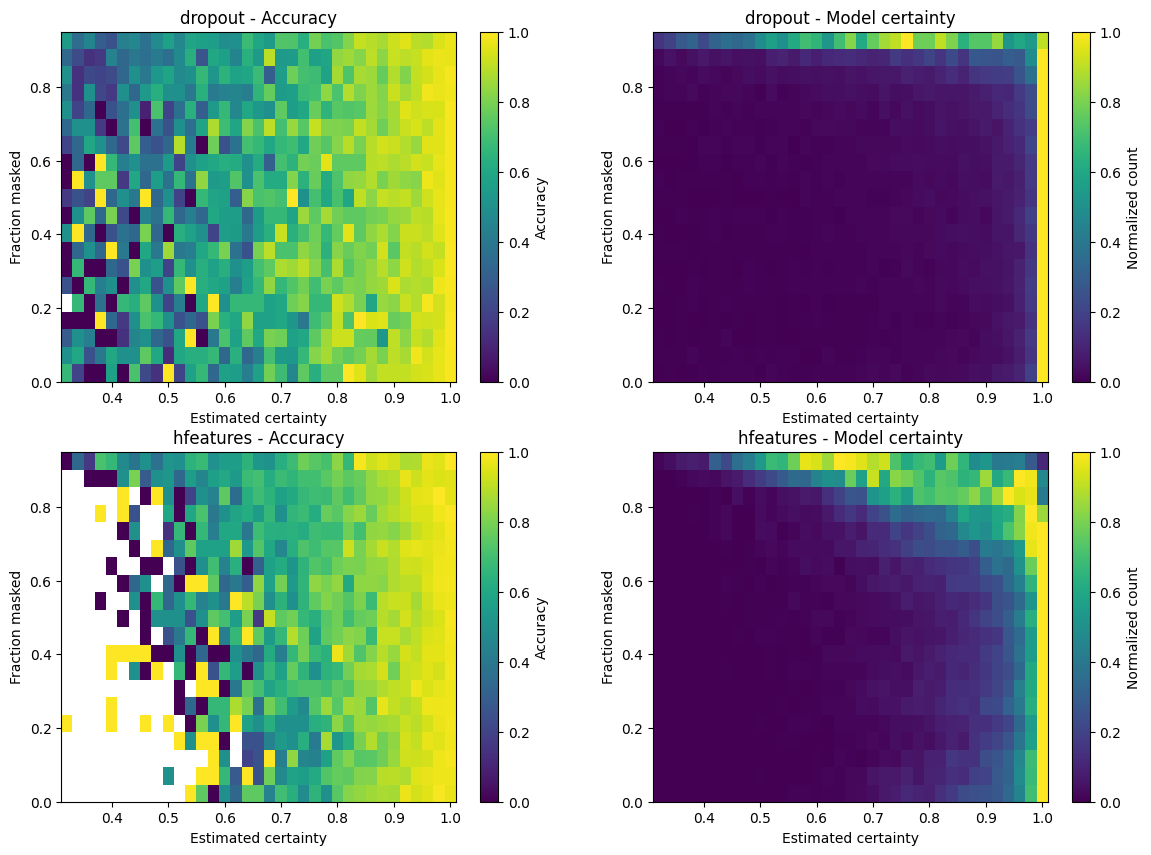

In [6]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
hbins = np.arange(0.3,1.02,0.02)
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_mix[type][drop_name]['acc_bin']
    predm = uncertainty_drops_mix[type][drop_name]['conf_bin']
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[0]}")
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

At a first glance, the noticeable drop in accuracies under high confidence, observed with the regular estimators (see certainty_estimators notebook), is not so evident here. Another remarkable difference is that the distributions of estimated certainties are more strongly displaced at high masking levels, specialy for the hfeatures-based estimator.

Let's have a closer look at accuracies obtained for selected ranges of certainty, comparing regular vs. mixture of estimators models.

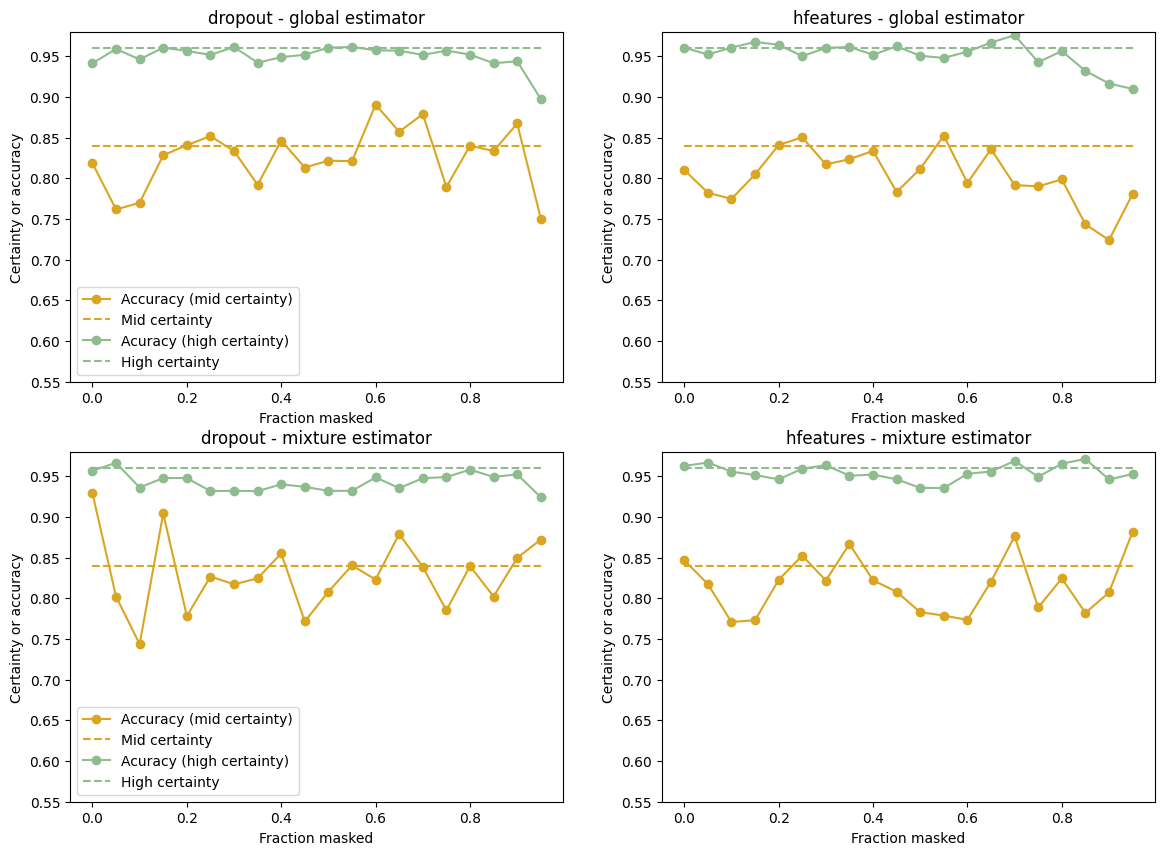

In [7]:
fig, axs = plt.subplots(2,2,figsize=(14,10))

c_ranges = np.stack((np.arange(25,29),np.arange(31,35)),axis=1)
color_names = ['goldenrod','darkseagreen']

uncertainties = [uncertainty_drops_tunned,uncertainty_drops_mix]
uncertainty_names = ['global estimator','mixture estimator']

for p, uncertainty in enumerate(uncertainties):
    
    for i,type in enumerate(estimator_type):
    
        for c in range(2):
            pred_acc = uncertainty[type][drop_name]['acc_bin']
    
            axs[p,i].plot(fraction_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color=color_names[c])
            axs[p,i].plot(fraction_levels,np.tile(np.mean(uncertainty['model confidence'][c_ranges[:,c]]),20),'--',color=color_names[c])
            axs[p,i].set(xlabel='Fraction masked',ylabel='Certainty or accuracy',title=f"{type} - {uncertainty_names[p]}",ylim=[0.55,0.98])
        if i==0:
            axs[p,i].legend(['Accuracy (mid certainty)', 'Mid certainty','Acuracy (high certainty)','High certainty'])
plt.show()

Interestingly, the deviation between certainty and actual accuracy for the high masking level bins is not observable with the misture of estimators. The results look, however more noisy/biased across the whole range of masking levels, maybe due to the splitting of training data by masking level, which decreases the amount of data to train each estimator by 20x when compared with the whole dataset used to train the regular estimators.
To further confirm this observation, I checked the total error for the mixture of estimators accross CNN accuracies.

In [6]:
def calculate_total_error(uncertainty_drops,corruption_levels):
    
    xp = uncertainty_drops['model confidence']
    y_err = np.zeros((corruption_levels.shape[0],2))
    print(corruption_levels.shape[0])
    for i in range(corruption_levels.shape[0]):
        
#         for k in range(2):
#             ind_nan[k] = uncertainty_drops[estimator_type[k]][drop_name]['nan_bin'][i,:]
        
        yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_bin'][i,:],
               uncertainty_drops['hfeatures'][drop_name]['acc_bin'][i,:]]).T

        yp = np.where(np.isnan(yp),0,yp)
        #print(yp)

        yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_bin'][i,:],
                    uncertainty_drops['hfeatures'][drop_name]['conf_bin'][i,:]]).T
        y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
        
    return y_err

In [11]:
acc_masking = []
total_binned_error = []
for uncertainty in uncertainties:
    for type in estimator_type:
        inst = uncertainty[type][drop_name]['validation']['wrong']
        n_total = inst.size(1)
        n_wrong = torch.sum(inst,1)
        acc_masking.append(1-n_wrong/n_total)
    total_binned_error.append(calculate_total_error(uncertainty,fraction_levels))

20
20


In [7]:
from scipy.optimize import curve_fit

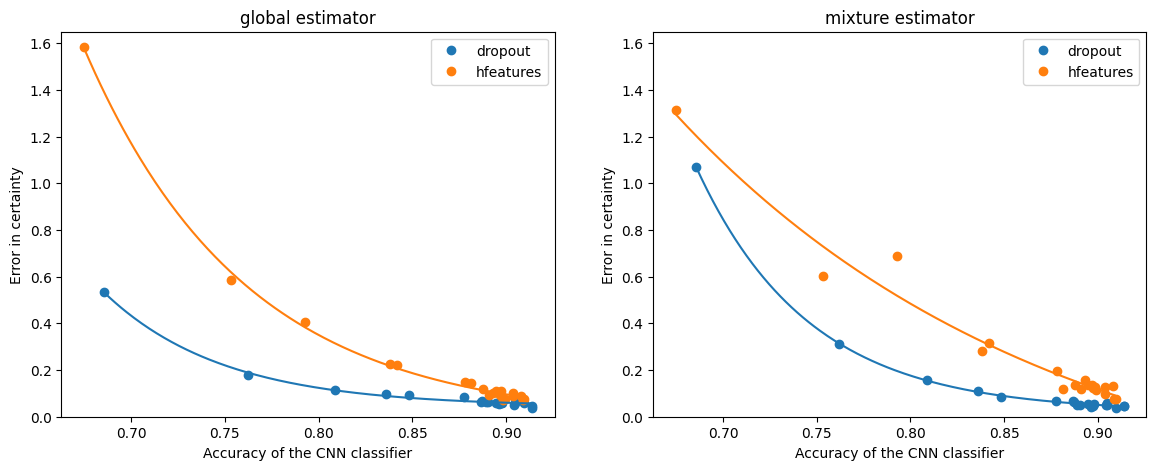

In [18]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

indplot = np.array([[0,1],[0,1]])
for p, uncertainty in enumerate(uncertainties):
    for i,type in enumerate(estimator_type): 
        pred_acc = uncertainty[type][drop_name]['acc_bin']
        #axs[1].plot(np.mean(pred_acc[:,c_ranges[:,2]],axis=1),acc_masking[i],'o')
        axs[p].plot(acc_masking[indplot[p,i]],total_binned_error[p][:,i],'o')
        axs[p].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty',ylim=[0,1.65],
                  title=uncertainty_names[p])
        axs[p].legend(estimator_type)
    
    # Get the default color cycle
    colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i in range(2):
        params1, _ = curve_fit(exp_decay, np.array(acc_masking[indplot[p,i]]),total_binned_error[p][:,i],p0=[50,7,0])
        
        xfit = np.arange(torch.min(acc_masking[indplot[p,i]]),torch.max(acc_masking[indplot[p,i]]),0.001)
        axs[p].plot(xfit,exp_decay(xfit,*params1),color=colors_default[i])
    
plt.show()

Overall, both global and mixture estimators show an exponential increase in error as the CNN accuracy decreases. The absolute values are comparable, with the dropout-based estimators show a slightly large error when the CNN classifier is not accurate. As mentioned before, this could be due to the less training data available for each of the estimators in the mixture model as compared with the global estimator. It is therefore expected that the performance of the mixture estimator improves if one uses a bigger training set.

## Conclusions
In this notebook I showed how to implement a certainty estimator based on a mixture of masking level-dependent estimators. The resulting model fixes the over-confidence bias of the global dataset-based estimators at high masking levels. The performance of the mixture estimator might be improved by training on a larger dataset.